# Online Chess Games - Exploration

Chess is a two-player strategy board game that has been around since the 6th century and played by millions worldwide.  Lichess.org is a major online chess server that is open-source.  In this notebook, I have performed an exploration on this [Dataset](https://www.kaggle.com/datasnaek/chess) of ~20,000 chess games from a selection* of users on the site Lichess.org.

*The selection criteria for the ~20,000 games: they were the most recent (as of Sept. 3rd, 2017, the dataset's creation) games taken from users of the top ~100 teams on Lichess.

**Contents**

[1. Dataset preparation](#1)
<br>[2. Overall Observations (Both Rated and Unrated)](#2)
<br>&nbsp;&nbsp;&nbsp;&nbsp;[2.1 Mean Rating](#2.1)
<br>&nbsp;&nbsp;&nbsp;&nbsp;[2.2 Victory Status](#2.2)
<br>&nbsp;&nbsp;&nbsp;&nbsp;[2.3 White Advantage](#2.3)
<br>&nbsp;&nbsp;&nbsp;&nbsp;[2.4 Length of Games](#2.4)
<br>&nbsp;&nbsp;&nbsp;&nbsp;[2.5 Number of Turns to Mate](#2.5)
<br>&nbsp;&nbsp;&nbsp;&nbsp;[2.6 Types of Victory](#2.6)
<br>&nbsp;&nbsp;&nbsp;&nbsp;[2.7 Wins by Lower Ranked Players (Upsets)](#2.7)
<br>&nbsp;&nbsp;&nbsp;&nbsp;[2.8 Castling Preference](#2.8)
<br>&nbsp;&nbsp;&nbsp;&nbsp;[2.9 Opening Preference](#2.9)
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.9.1 Favor White](#2.9.1)
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.9.2 Favor Black](#2.9.2)
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.9.3 Favor Draws](#2.9.3)
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.9.4 Scholar's Mate](#2.9.4)
<br>[3. Difference Between Rated and Unrated](#3)
<br>&nbsp;&nbsp;&nbsp;&nbsp;[3.1 Mean Rating](#3.1)
<br>&nbsp;&nbsp;&nbsp;&nbsp;[3.2 Victory Status by Rating](#3.2)
<br>&nbsp;&nbsp;&nbsp;&nbsp;[3.3 White Advantage](#3.3)
<br>&nbsp;&nbsp;&nbsp;&nbsp;[3.4 Length of Games](#23.4)
<br>&nbsp;&nbsp;&nbsp;&nbsp;[3.5 Number of Turns to Mate](#3.5)
<br>&nbsp;&nbsp;&nbsp;&nbsp;[3.6 Types of Victory](#3.6)
<br>&nbsp;&nbsp;&nbsp;&nbsp;[3.7 Wins by Lower Ranked Players (Upsets)](#3.7)
<br>&nbsp;&nbsp;&nbsp;&nbsp;[3.8 Castling Preference](#3.8)
<br>&nbsp;&nbsp;&nbsp;&nbsp;[3.9 Opening Preference](#3.9)
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.6.1 Favor White](#3.9.1)
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.6.2 Favor Black](#3.9.2)
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.6.3 Favor Draws](#3.9.3)
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.6.4 Scholar's Mate](#3.9.4)
<br>[4. Conclusion](#4)

<br><br>

## <a id="1">1. Dataset Preparation</a>

As the first step, let us import the required libraries, load the dataset, check for missing data, remove duplicates, and create some additional features. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.stats import ttest_ind
import re
from statistics import mode
%matplotlib inline

#Read csv file
games = pd.read_csv('games.csv') #both rated and unrated games

#Data Size Check
print("Dataset Size:  ", games.shape)

#Check if there are any missing data
print("Any Missing Data:  ", games.isnull().values.any())

#Remove duplicates
games = games.drop_duplicates('id', 'first')

#Data Size Check Again, and see we removed a few duplicates
print("Dataset Size:  ", games.shape)

Dataset Size:   (20058, 16)
Any Missing Data:   False
Dataset Size:   (19113, 16)


### Additional Features

In [2]:
### IN CASE I NEED TO ADD ANYTHING... PROBABLY NOT.

## <a id="2">2. Overall Observations (Both Rated and Unrated)</a>

The overall question we're asking: is there a difference between playing a RATED game versus an UNRATED game?  Each player is given a *rating* on the site proportional to their skill (higher is better).  UNRATED games will not affect the player's ratings, while RATED games will shift the player's rating depending on the outcome.  Will the quality of games change if there's risk and reward?

Along the way, we will also check how games differ between lower and higher rated players.

There are many factors we are considering.  Each section contains a factor for consideration, which will first be checked against the overall dataset before being compared between the RATED and UNRATED.

### <a id="2.1">2.1 Mean Rating</a>

We can calculate the average rating of the game by taking the mean of the two player's ratings.

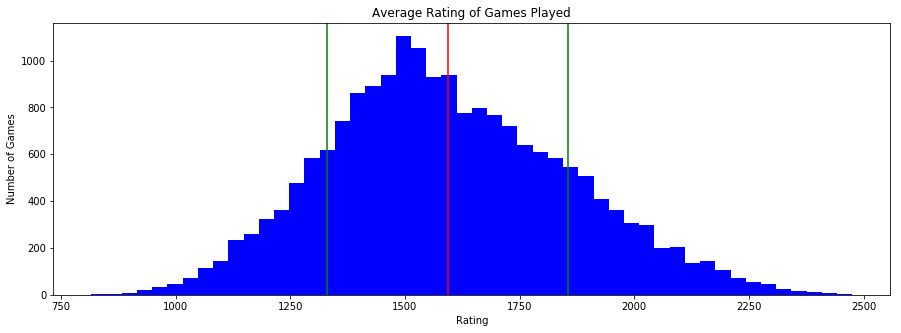

mode      1500.0
count    19113.000000
mean      1593.672762
std        262.541423
min        816.500000
25%       1409.500000
50%       1570.000000
75%       1772.500000
max       2475.500000
Name: mean_rating, dtype: float64


In [3]:
#Adding another column calculating average of two player's ratings
games['mean_rating'] = (games['white_rating'] + games['black_rating']) / 2

def GamesHist(df, bins, color, column, xname, title):
    #Finding average of MeanRatings
    nd_mean = np.mean(df[column])
    nd_std = np.std(df[column])
    
    #Creating Histogram
    plt.figure(figsize=(15,5))

    plt.hist(df[column], bins=bins, color=color)
    plt.title(title)
    plt.xlabel(xname)
    plt.ylabel('Number of Games')
    plt.axvline(x=nd_mean, color = 'red')
    plt.axvline(x=nd_mean + nd_std, color = 'green')
    plt.axvline(x=nd_mean - nd_std, color = 'green')
    plt.show()
    
    #Printing additional info
    print( 'mode     ', mode(df[column]))
    print( df[column].describe())
    
GamesHist(games, 50, 'blue', 'mean_rating', 'Rating', 'Average Rating of Games Played')

That chart shows what the average rating is of the games played.  It is skewed by players playing multiple games.  If we want to see what the average player's rating is...

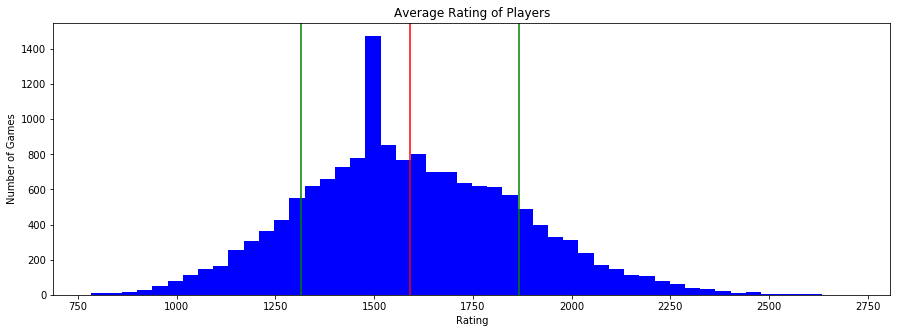

mode      1500.0
count    15635.000000
mean      1590.691088
std        275.587581
min        784.000000
25%       1407.000000
50%       1564.000000
75%       1777.750000
max       2711.500000
Name: mean_rating, dtype: float64


In [4]:
###########################################################################
###########################################################################
########################### GET BACK TO LATER...###########################
###########################################################################
###########################################################################

def PlayerRatings_Combined(df):
    #Create dataframes of user's average ratings when playing certain color
    df_w = df.rename(columns= {'white_id' : 'player_id'}) 
    df_white = df_w.groupby(['player_id']).mean()
    df_white = df_white['white_rating']
    
    df_b = df.rename(columns = {'black_id': 'player_id'})
    df_black = df_b.groupby(['player_id']).mean()
    df_black = df_black['black_rating']
    
    #merging two dataframes based on player_ID
    df_combined = pd.merge(df_white, df_black, on='player_id', how="outer")
    df_combined['mean_rating'] = (df_combined.mean(axis=1))
    
    return df_combined

games_players = PlayerRatings_Combined(games)

# There are some players missing because they're not in both black and white side

GamesHist(games_players, 50, 'blue', 'mean_rating', 'Rating', 'Average Rating of Players')

What we see here is a huge spike around the 1500 rating.  As all new Lichess accounts start at 1500 rating, it is greatly skewing our results.  Let me filter that out...

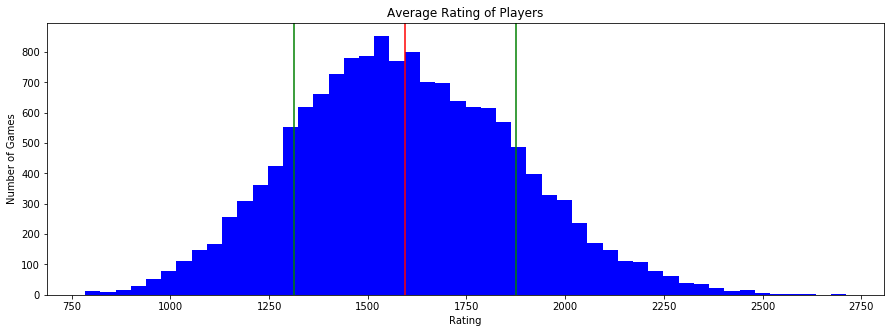

mode      1461.0
count    14949.000000
mean      1594.852843
std        281.139104
min        784.000000
25%       1396.500000
50%       1580.000000
75%       1788.000000
max       2711.500000
Name: mean_rating, dtype: float64


In [5]:
#Removing players with the rating of exactly 1500
games_players = games_players.loc[games_players['mean_rating'] != 1500]

GamesHist(games_players, 50, 'blue', 'mean_rating', 'Rating', 'Average Rating of Players')

That looks more like a normal distribution, which is what we expect.

### <a id="2.2">2.2 Victory Status</a>

There are four different ways for a game to end: getting check-mated (mate), resigning, running out of time, or be in a position where neither side can win (draw).  Is there a difference between high/low rated players?

In [6]:
games['victory_status'].value_counts()

resign       10695
mate          5974
outoftime     1598
draw           846
Name: victory_status, dtype: int64

In [7]:
victory_stats = games.groupby('victory_status')
victory_stats.count()

,id,rated,created_at,last_move_at,turns,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply,mean_rating
victory_status,,,,,,,,,,,,,,,,
draw,846,846,846,846,846,846,846,846,846,846,846,846,846,846,846,846
mate,5974,5974,5974,5974,5974,5974,5974,5974,5974,5974,5974,5974,5974,5974,5974,5974
outoftime,1598,1598,1598,1598,1598,1598,1598,1598,1598,1598,1598,1598,1598,1598,1598,1598
resign,10695,10695,10695,10695,10695,10695,10695,10695,10695,10695,10695,10695,10695,10695,10695,10695


### <a id="2.3">2.3 White Advantage</a>

Whoever goes first in a turn-based game has an inherient advantage.  How much of an advantage do those playing white get?  Does it differ based on rating levels?

In [8]:
games['winner'].value_counts()

white    9545
black    8680
draw      888
Name: winner, dtype: int64

### <a id="2.4">2.4 Length of Games</a>

How many moves are in a typical game, including all types of win conditions (mating, resigning, out-of-time, draw).

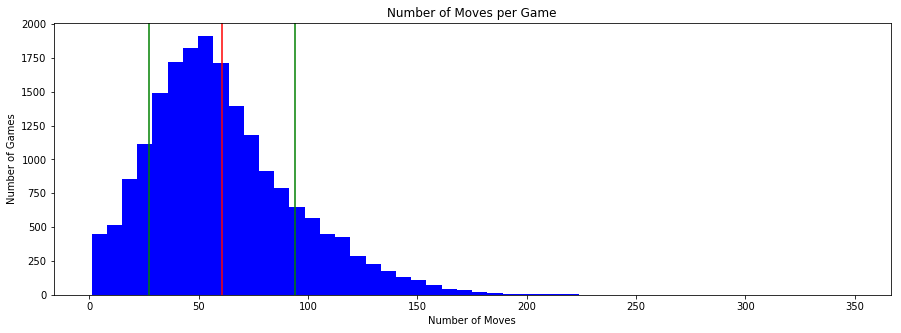

mode      45
count    19113.000000
mean        60.513839
std         33.488264
min          1.000000
25%         37.000000
50%         55.000000
75%         79.000000
max        349.000000
Name: turns, dtype: float64


In [9]:
GamesHist(games, 50, 'blue', column='turns', xname='Number of Moves', title='Number of Moves per Game')

### <a id="2.5">2.5 Number of Turns to Mate</a>

What is the average number of moves that leads to mate?

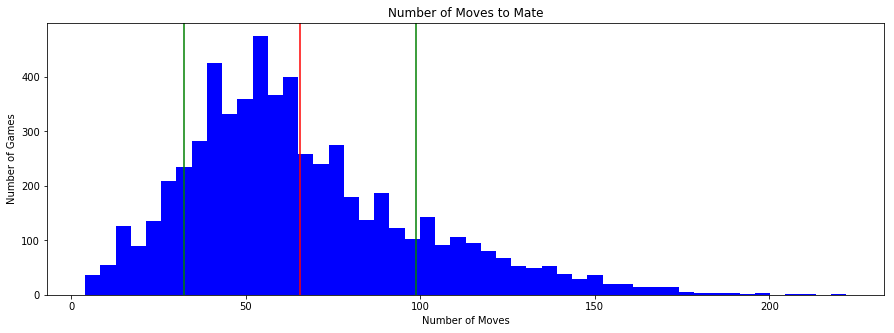

mode      52
count    5974.000000
mean       65.568966
std        33.166256
min         4.000000
25%        42.000000
50%        59.000000
75%        83.000000
max       222.000000
Name: turns, dtype: float64


In [10]:
games_mate = games.loc[games['victory_status'] == 'mate']

GamesHist(games_mate, 50, 'blue', 'turns', 'Number of Moves', 'Number of Moves to Mate')

### <a id="2.6">2.6 Types of Victory</a>

I forgot why I have this here...

### <a id="2.7">2.7 Wins by Lower Ranked Players (Upsets)</a>

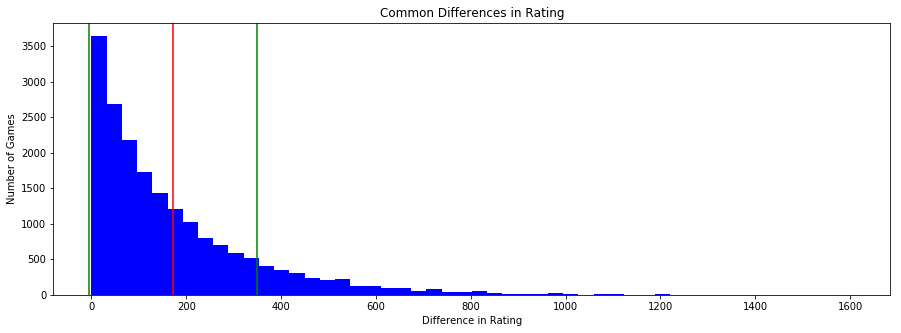

mode      0
count    19113.000000
mean       172.336786
std        177.702696
min          0.000000
25%         46.000000
50%        115.000000
75%        240.000000
max       1605.000000
Name: rating_difference, dtype: float64


In [11]:
games['rating_difference'] = abs(games['white_rating'] - games['black_rating'])

GamesHist(games, 50, 'blue', 'rating_difference', 'Difference in Rating', 'Common Differences in Rating')


In [16]:
#Removing draws (neither side wins) and equal rated games (no underdog)
games = games.loc[~games['winner'].str.contains('draw')]
games = games.loc[games['white_rating'] != games['black_rating']]

def set_color(row):
    if row["white_rating"] < row["black_rating"]:
        return "white"
    else:
        return "black"

#Creating column for which color has the lower rating
games = games.assign(underdog=games.apply(set_color, axis=1))

#Creating column for if the underdog won
games['upset'] = False
games.loc[(games['winner'] == games['underdog']), ['upset']] = [True]

games.head(5)

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply,mean_rating,rating_difference,underdog,upset
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5,1345.5,309,black,False
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4,1291.5,61,black,True
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3,1498.0,4,white,True
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3,1446.5,15,white,True
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5,1496.0,54,black,False


### <a id="2.8">2.8 Castling Preference</a>

### <a id="2.9">2.9 Opening Preference</a>

Does a certain type of opening favor a certain color?

#### <a id="2.9.1">2.9.1 Favor White</a>

#### <a id="2.9.2">2.9.2 Favor Black</a>

#### <a id="2.9.3">2.9.3 Favor Draws</a>

#### <a id="2.9.4">2.9.4 Scholar's Mate</a>

## <a id="3">3. Difference Between Rated and Unrated</a>

### Creating Seperate Datasets
Time to split between rated and unrated games

In [13]:
#I'll split between rated and unrated games
rated_games = games[games.rated] #only rated games
unrated_games = games[~games.rated] #only unrated games
print("Rated Dataset Size:  " + str(rated_games.shape[0]))
print("Unrated Dataset Size:  " + str(unrated_games.shape[0]))

Rated Dataset Size:  15467
Unrated Dataset Size:  3646


### <a id="3.1">3.1 Mean Rating</a>

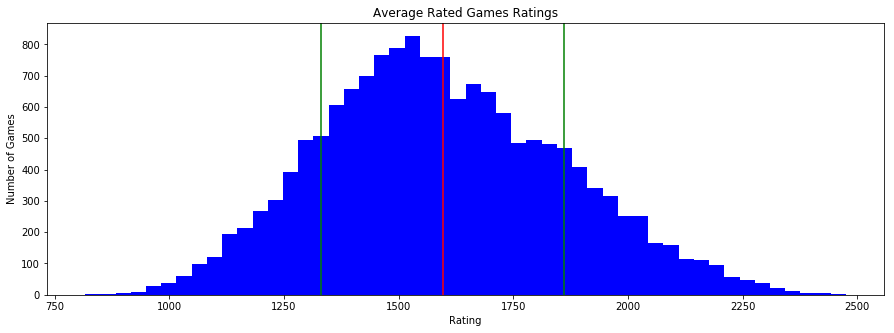

mode      1500.0
count    15467.000000
mean      1595.765048
std        264.691853
min        816.500000
25%       1408.500000
50%       1574.500000
75%       1777.750000
max       2475.500000
Name: mean_rating, dtype: float64


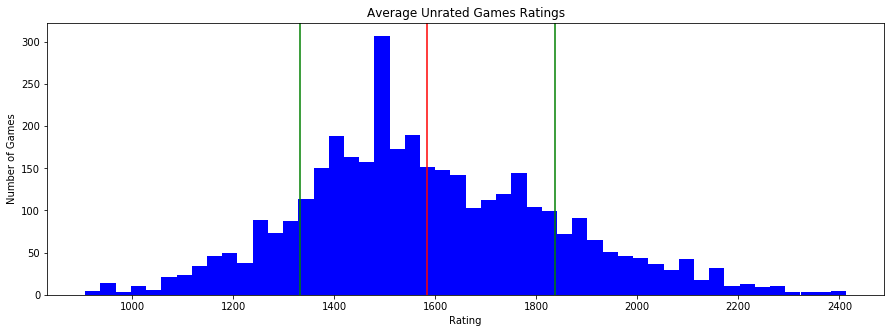

mode      1500.0
count    3646.000000
mean     1584.796901
std       253.058942
min       907.500000
25%      1414.000000
50%      1546.500000
75%      1756.000000
max      2413.500000
Name: mean_rating, dtype: float64


In [14]:
GamesHist(rated_games, 50, 'blue', 'mean_rating', 'Rating', 'Average Rated Games Ratings')

GamesHist(unrated_games, 50, 'blue', 'mean_rating', 'Rating', 'Average Unrated Games Ratings')

### <a id="3.2">3.2 Victory Status</a>

### <a id="3.3">3.3 White Advantage</a>

### <a id="3.4">3.4 Length of Games</a>

### <a id="3.5">3.5 Number of Turns to Mate</a>

### <a id="3.6">3.6 Types of Victories</a>

### <a id="3.7">3.7 Wins by Lower Ranked Players (Upsets)</a>

### <a id="3.8">3.8 Castling Preference</a>

### <a id="3.9">3.9 Opening Preference</a>

#### <a id="3.9.1">3.9.1 Favor White</a>

#### <a id="3.9.2">3.9.2 Favor Black</a>

#### <a id="3.9.3">3.9.3 Favor Draws</a>

#### <a id="3.9.4">3.9.4 Scholar's Mate</a>

## <a id="4">4. Conclusion</a>